# **Plot drafting**

Creating plots with the cleaned dataset

## A) Imports and last cleaning steps

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [2]:
# set options
pd.options.mode.chained_assignment = None
pd.options.display.min_rows = 30
pd.options.display.max_rows = 100
pd.set_option("display.max_colwidth", 100)

In [3]:
# load the CSV file brands from the directory data 
brands = pd.read_csv("brands.csv")

In [4]:
# Import  all orders with categories,the cleaned and merged dataset, as all_orders_cat.csv from directory data
orders_cat = pd.read_csv("all_orders_cat.csv")

In [5]:
# Format the date columns to datetime type
orders_cat["created_date"] = pd.to_datetime(orders_cat["created_date"])
orders_cat["date"] = pd.to_datetime(orders_cat["date"])

In [6]:
# Merge the orders dataframe with brands and sort unknown brands to Others
orders_cat["short"] = orders_cat.sku.str.slice(0,3)
orders_cat_b = orders_cat.merge(brands,how="left")
orders_cat_b.loc[orders_cat_b["long"].isna()==True,"long" ] = "Others"


In [ ]:
# create a column Year and Month
orders_cat_b["year_month"] = orders_cat_b["date"].dt.strftime("%y-%m")

In [ ]:
orders_cat_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85793 entries, 0 to 85792
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   id                   85793 non-null  int64         
 1   order_id             85793 non-null  int64         
 2   sku                  85793 non-null  object        
 3   name                 85793 non-null  object        
 4   desc                 85793 non-null  object        
 5   type                 85793 non-null  object        
 6   category             85793 non-null  object        
 7   created_date         85793 non-null  datetime64[ns]
 8   date                 85793 non-null  datetime64[ns]
 9   state                85793 non-null  object        
 10  unit_price           85793 non-null  float64       
 11  product_quantity     85793 non-null  int64         
 12  unit_price_total     85793 non-null  float64       
 13  price                85793 non-

## B) Revenue per month and average discounts

Show the seasonality in revenue and how that relates to an average discount per month

In [ ]:
revenue_month = orders_cat_b.copy()

In [ ]:
# group revenue (unit price total) and average discounts by month
revenue_month = revenue_month.groupby("year_month").agg(sum_revenue=("unit_price_total","sum"), avg_discount=("discount_percentage","mean")).reset_index()

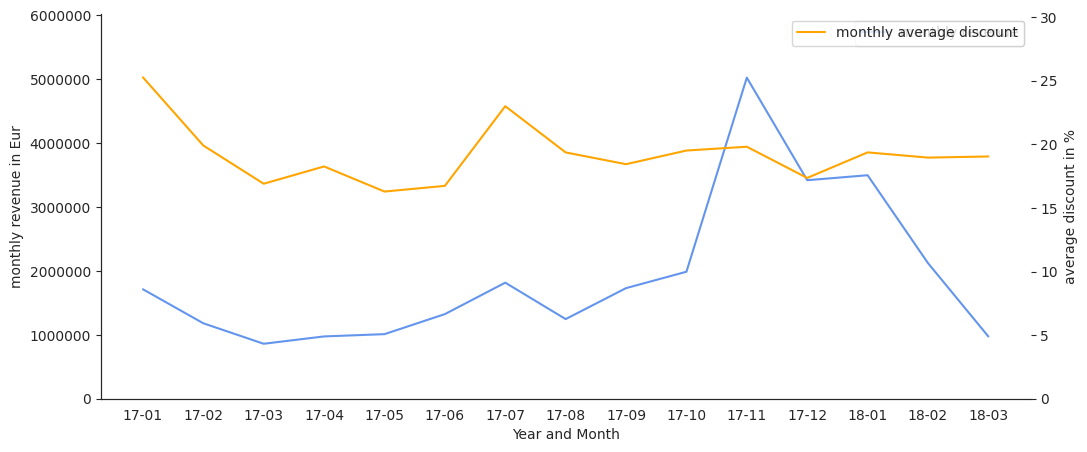

In [ ]:
sns.set_style("white")
fig, ax1 = plt.subplots(figsize=(12,5))
ax2 = ax1.twinx()
sns.set_style("white")

# revenue line
( sns.lineplot(
    data = revenue_month,
    x = "year_month",
    y = "sum_revenue",
    color = "cornflowerblue",
    label ="monthly revenue",
    ax=ax1
));
# discount line
(sns.lineplot(
    data = revenue_month,
    x='year_month',
    y='avg_discount',
    color='orange',
    ax=ax2,
    label='monthly average discount'
));
# Set Axes Labels and values
ax1.set_xlabel('Year and Month')
ax1.set_ylabel("monthly revenue in Eur")
ax2.set_ylabel ("average discount in %")
ax1.set_ylim(0,(revenue_month["sum_revenue"].max())+1000000)
ax2.set_ylim(0,(revenue_month["avg_discount"].max())+5)
ax1.get_yaxis().get_major_formatter().set_scientific(False)

sns.despine()

plt.show()




---



## C) Evaluation of the seasonality of discounts

How do discounts influence the seasonality?  
As the dataset contains only a small amount of orders without a discount through the whole year an equal sample of orders with disocunts is created to level the effects

In [ ]:
df_disc_year = orders_cat_b.copy()

prepare the dataframe with a column for discounts Yes or No

In [ ]:
# create the column discount Yes or No
df_disc_year["discount"]=""
df_disc_year.loc[(df_disc_year.discount_percentage== 0),"discount"] = "No"
df_disc_year.loc[(df_disc_year.discount_percentage > 0),"discount"] = "Yes"

In [ ]:
# Take a list with orderlines with no discount
no_discount_lst = df_disc_year.loc[df_disc_year.discount =="No","id"].to_list()

# 4090 orders have no dicount
len(no_discount_lst)

4099

Create a new dataframe with an equal sample of discounted and not discounted orders

In [ ]:
# Create a dataframe without discounts
no_discount_df = df_disc_year.loc[df_disc_year.discount == "No",:]

# Create a dataframe with a random sample of the same size as no discounted orders
yes_discount_df = df_disc_year.loc[df_disc_year.discount == "Yes",:].sample(len(no_discount_lst))

# Concat
disc_comp = pd.concat([no_discount_df,yes_discount_df])

In [ ]:
#group the extract by time and discount
disc_comp = disc_comp.groupby(["year_month","discount"]).agg({"unit_price_total": "sum"}).reset_index()

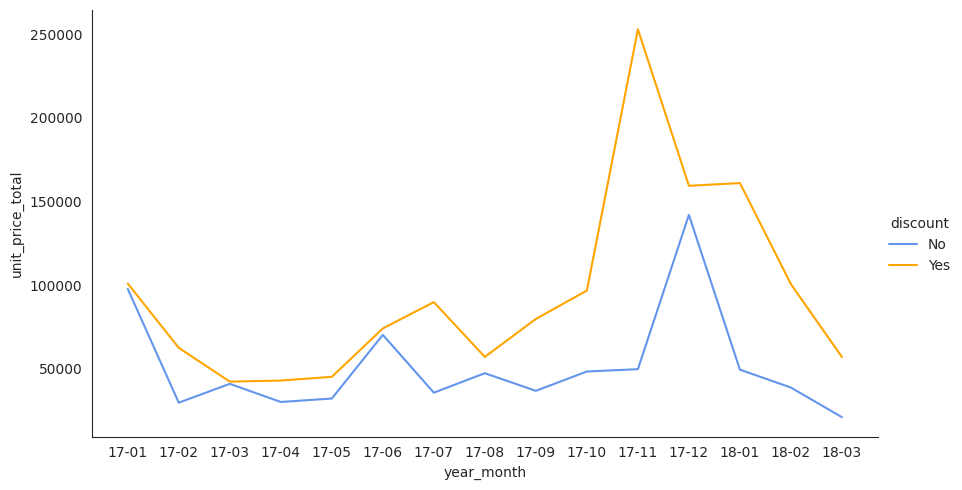

In [ ]:
sns.set_style("white")

month_plot2 = (sns.relplot(
                data = disc_comp,
                kind = "line",
                x = "year_month",
                y = "unit_price_total",
                hue = "discount",
                palette = ["cornflowerblue","orange"],
                aspect = 1.8,

               ));

sns.despine()

plt.show()



---



## D)  Discounts per categorie and price group

How do discounts differ for price groups and categories?  
Evaluation of patterns.

In [ ]:
avg_prices = orders_cat_b.copy()
quantity = orders_cat_b.copy()

In [ ]:
avg_prices = avg_prices.groupby(["category"]).agg({"discount_percentage":"mean","price":"mean"}).reset_index()

In [ ]:
quantity = quantity.groupby(["category"]).agg({"discount_percentage":"mean","product_quantity":"sum"}).reset_index()

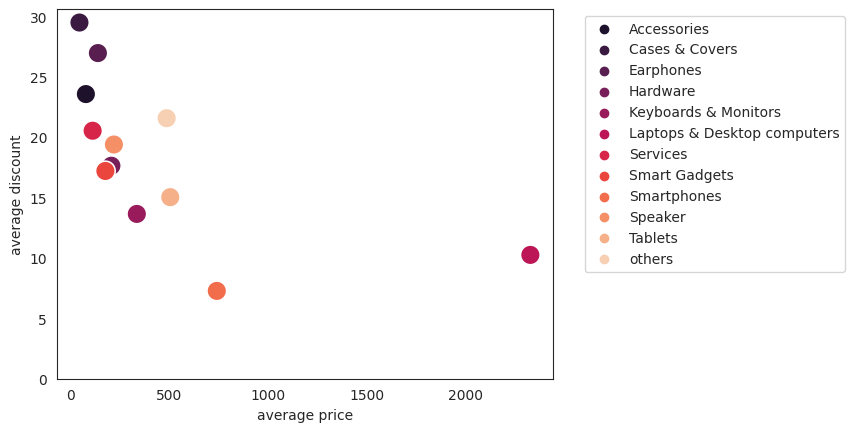

<Figure size 900x500 with 0 Axes>

In [ ]:
sns.set_style("white")



price_disc = (sns.scatterplot(
                data=avg_prices,
                x="price",
                y="discount_percentage",
                hue="category",
                palette="rocket",
                s=200
))

# Set Axes Labels and values
price_disc.set_xlabel('average price')
price_disc.set_ylabel("average discount")
price_disc.set_ylim(0)
plt.figure(figsize=(9,5))
sns.despine()
price_disc.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

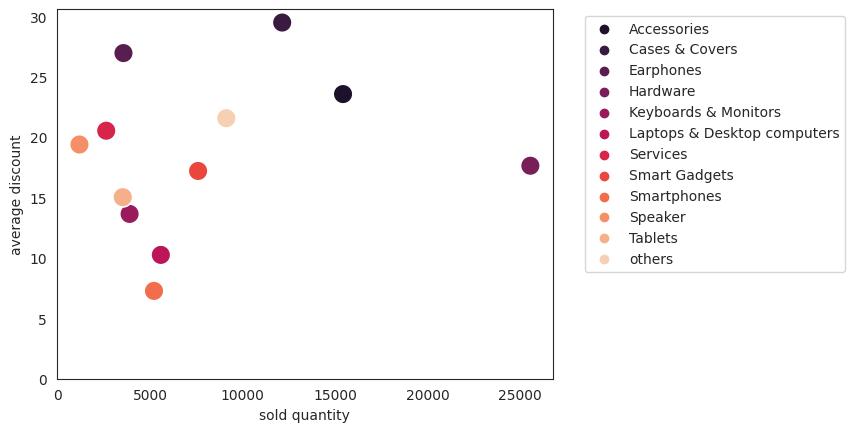

<Figure size 900x500 with 0 Axes>

In [ ]:
sns.set_style("white")



units_disc = (sns.scatterplot(
                data=quantity,
                x="product_quantity",
                y="discount_percentage",
                hue="category",
                palette="rocket",
                s=200
))

# Set Axes Labels and values
units_disc.set_xlabel('sold quantity')
units_disc.set_ylabel("average discount")
units_disc.set_ylim(0)
plt.figure(figsize=(9,5))
sns.despine()
units_disc.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

## E) Evaluation of effects of discount effects on revenue


How does the discount impact sales and revenue?   
As the dataset does not have a timeframe where products are sold with no discounts as a baseline, a sample is used to show the effect.

The products that have been sold without and with a discount within the dataset
create that sample.

*   To take out seasonality effects - November and December are excluded
*   The products in the sample have been sold on more days with discounts than without. To create comparable averages revenue per day is calculated
*   For better visualisation aggregated on category and monthly level  





In [ ]:
disc_sample = orders_cat_b.copy()

Extract the data sample with a new column discount or no discount

In [ ]:
# Create a column to sort orderlines with discount and no discount
disc_sample["discount"]=""
disc_sample.loc[(disc_sample.discount_percentage== 0),"discount"] = "No"
disc_sample.loc[(disc_sample.discount_percentage > 0),"discount"] = "Yes"

# make a list with products (sku) discounts and no discounts
yes_lst = list(disc_sample.loc[(disc_sample.discount=="Yes"),"sku"])
no_lst = list(disc_sample.loc[(disc_sample.discount=="No"),"sku"])

# find the products (skus) that are in both lists
sku_sample = []
for sku in yes_lst:
    if sku in no_lst:
        sku_sample.append(sku)

# take out the duplicated SKUs
sku_sample2= list(dict.fromkeys(sku_sample) )

In [ ]:
# around 500 products left in the list
len(sku_sample2)

512

Integrate Columns with Year, Month and Day into the dataframe.
Exclude November and December from the dataframe

In [ ]:
#create a separate colum with year and month and one with days
disc_sample["day"] = disc_sample["date"].dt.day

In [ ]:
# extract all orders between January and October 2017 including
df_disc_mayoct = disc_sample.loc[disc_sample["year_month"].between("17-01","17-10"),:]
# extract all orders between January and March  2018 including
df_disc_janmar= disc_sample.loc[(disc_sample["year_month"].between("18-01","18-03")),:]

# concat both sets
df_disc_month= pd.concat([df_disc_mayoct,df_disc_janmar])

Extract only those orders with products with and without discounts.

In [ ]:
# New dataset on the condensed SKUS with no and yes discounts
df_disc_month = df_disc_month.loc[df_disc_month.sku.isin(sku_sample2),:]

Calculate the average sales and revenue per day

In [ ]:
#group the extract by product quantity and count the unique number of days
df_disc_filt = df_disc_month.groupby(["year_month","category","discount"]).agg({"product_quantity": "sum","day":"nunique"}).reset_index()
#group the extract by revenue and count the unique number of days
df_disc_filt_rev = df_disc_month.groupby(["year_month","category","discount"]).agg({"unit_price_total": "sum","day":"nunique"}).reset_index()

In [ ]:
# calculate the sum of products per day
df_disc_filt["products_per_day"] = (df_disc_filt["product_quantity"]/df_disc_filt["day"]).round(0)
#calculate the revenue per day
df_disc_filt_rev["revenue_per_day"] = (df_disc_filt_rev["unit_price_total"]/df_disc_filt_rev["day"]).round(0)

In [ ]:
# group again to get a daily average per month
df_disc_filt2 = df_disc_filt.groupby(["category","discount"]).agg({"products_per_day":"mean"}).reset_index()
df_disc_filt2["products_per_day"] = df_disc_filt2["products_per_day"].round(1)
df_disc_filt_rev2 = df_disc_filt_rev.groupby(["category","discount"]).agg({"revenue_per_day":"mean"}).reset_index()
df_disc_filt_rev2["revenue_per_day"] = df_disc_filt_rev2["revenue_per_day"].round(1)

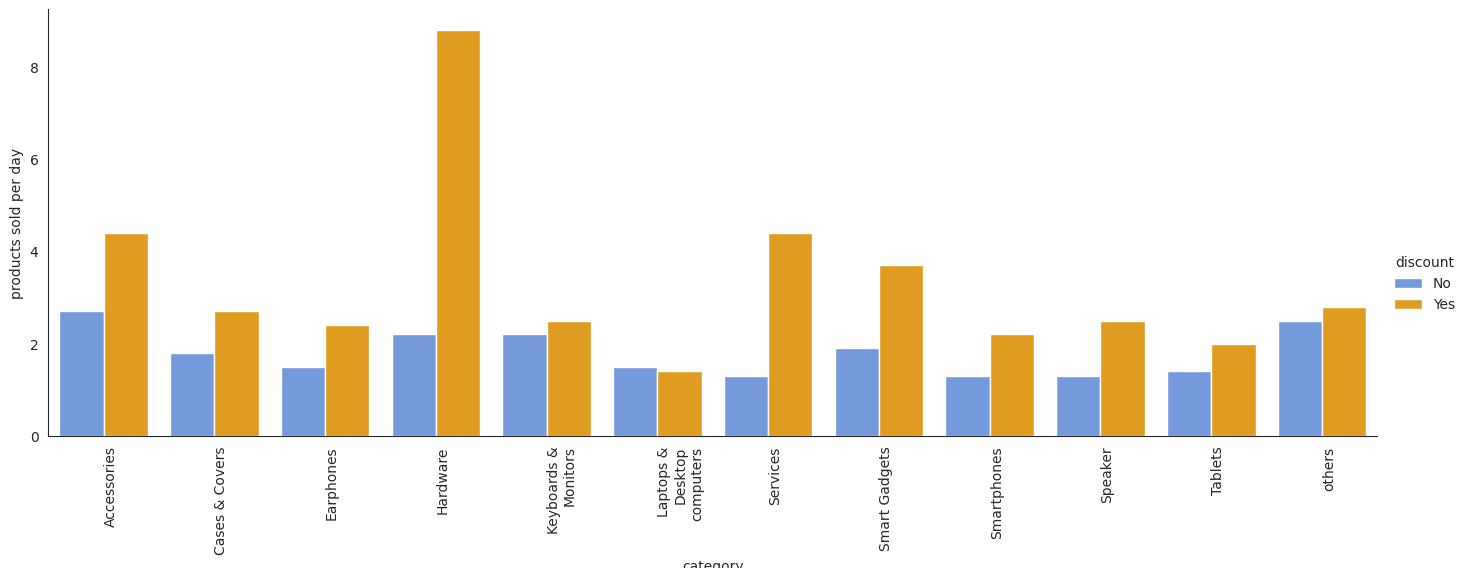

In [ ]:
 sns.set_style("white")

plot_absolute = (sns.catplot(
              data=df_disc_filt2,
              kind ="bar",
              x="category",
              y="products_per_day",
              hue = "discount",
              aspect = 2.8,
              palette = ["cornflowerblue","orange"],
              errorbar=None
));
plt.xticks(rotation=90, ha='right', wrap=True)
plot_absolute.set_ylabels("products sold per day" )


plt.show()

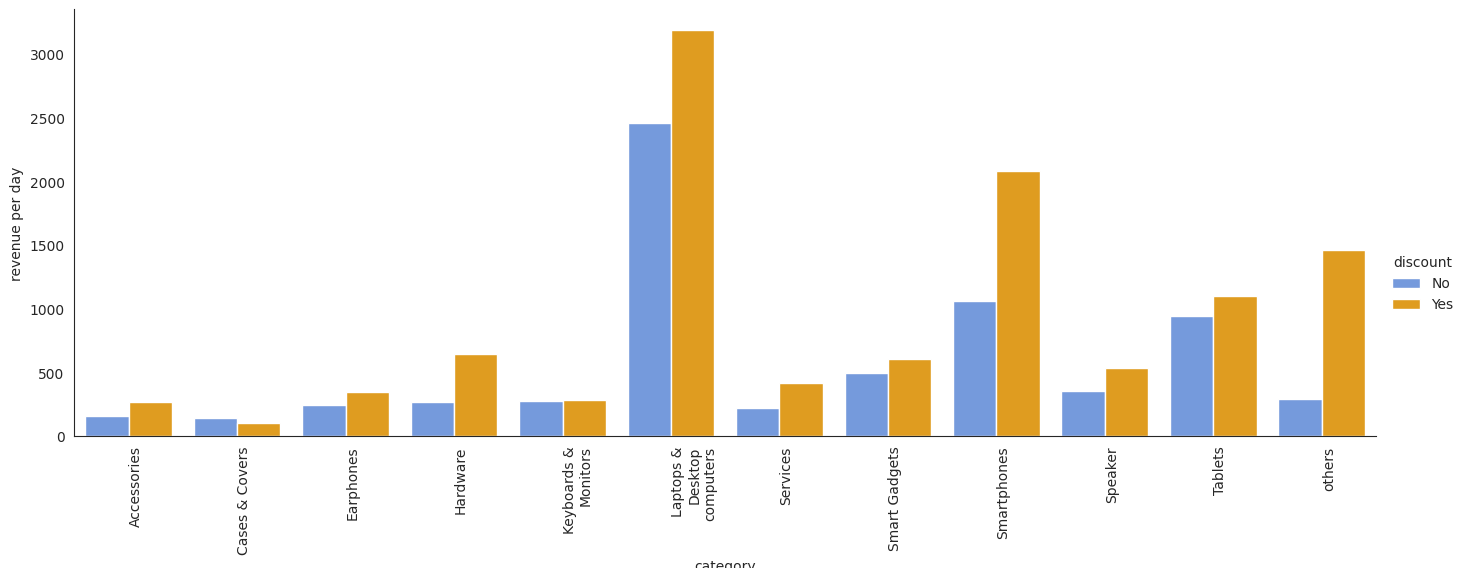

In [ ]:
 sns.set_style("white")

plot_absolute = (sns.catplot(
              data=df_disc_filt_rev2,
              kind ="bar",
              x="category",
              y="revenue_per_day",
              hue = "discount",
              aspect = 2.8,
              palette = ["cornflowerblue","orange"],
              errorbar=None
));
plt.xticks(rotation=90, ha='right', wrap=True)
plot_absolute.set_ylabels("revenue per day" )


plt.show()